<a href="https://colab.research.google.com/github/jmo2171/ml-climate/blob/main/src/wildfire_causal_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [16]:
! pip install dowhy

In [17]:
import pandas as pd
import dowhy
from dowhy import CausalModel, gcm
import networkx as nx
import numpy as np

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!pip install scikit-learn==1.4.2
# do why requires an older version of sklearn
import sklearn
print(sklearn.__version__)

1.4.2


# load data

In [20]:
data = pd.read_csv("/content/drive/MyDrive/Spring 2025/ML and Climate/wildfire_project/fire_earth_data.csv")

# causal model

In [21]:
print(data.columns.tolist())
drop_cols = ['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE_CLASS', 'FIRE_YEAR', 'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'date', 'dead_fuel_100','max_temp_K', 'min_temp_K']
data = data.drop(columns=drop_cols)

['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'FIRE_YEAR', 'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'date', 'dead_fuel_100', 'dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_K', 'min_temp_K', 'precipitation', 'wind_speed', 'max_temp_C', 'min_temp_C', 'population_density', 'vegetation', 'drought_index']


In [22]:

print(data.shape[0])
data = data.dropna()
print(data.shape[0])

189550
120903


In [23]:
data_np = data.to_numpy()

## unused

In [24]:
causal_graph1 = """
digraph {
    humidity -> FIRE_SIZE;
    precipitation -> FIRE_SIZE;
    wind_speed -> FIRE_SIZE;
    drought_index -> FIRE_SIZE;
    dead_fuel_1000 -> FIRE_SIZE;
    energy_release -> FIRE_SIZE;
    max_temp_C -> FIRE_SIZE;
    min_temp_C -> FIRE_SIZE;
    vegetation -> FIRE_SIZE;
    population_density -> FIRE_SIZE;
    drought_index -> dead_fuel_1000;
}
"""


In [25]:
# model = CausalModel(
#     data=data,
#     treatment=['humidity', 'precipitation', 'wind_speed', 'dead_fuel_1000', 'drought_index'],
#     outcome='FIRE_SIZE',
#     graph=causal_graph1
# )

# # Visualize the model
# model.view_model()

# # Identify causal effect
# identified_estimand = model.identify_effect()

# # Estimate causal effect
# causal_estimate = model.estimate_effect(
#     identified_estimand,
#     method_name="backdoor.linear_regression"
# )

# print(causal_estimate)


## first pass

In [26]:
causal_graph = nx.DiGraph([
    ('humidity','FIRE_SIZE'),
    ('humidity','dead_fuel_1000'),
    ('precipitation','FIRE_SIZE'),
    ('precipitation','humidity'),
    ('precipitation','drought_index'),
    ('precipitation','vegetation'),
    ('wind_speed','FIRE_SIZE'),
     ('drought_index','FIRE_SIZE'),
      ('drought_index','energy_release'),
       ('drought_index','vegetation'),
        ('dead_fuel_1000','FIRE_SIZE'),
         ('dead_fuel_1000','energy_release'),
          ('energy_release','FIRE_SIZE'),
           ('max_temp_C','humidity'),
           ('max_temp_C','drought_index'),
            ('min_temp_C','humidity'),
             ('vegetation','dead_fuel_1000'),
              ('population_density','FIRE_SIZE'),
               ('population_density','vegetation'),
                ('drought_index','dead_fuel_1000'),
                 ('drought_index','vegetation')
])

In [27]:
causal_model = gcm.StructuralCausalModel(causal_graph)


In [28]:
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data)


In [29]:
print(auto_assignment_summary)


When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

In [30]:
gcm.fit(causal_model, data)


Fitting causal mechanism of node population_density: 100%|██████████| 11/11 [00:03<00:00,  2.96it/s]


Test permutations of given graph: 100%|██████████| 50/50 [05:26<00:00,  6.52s/it]


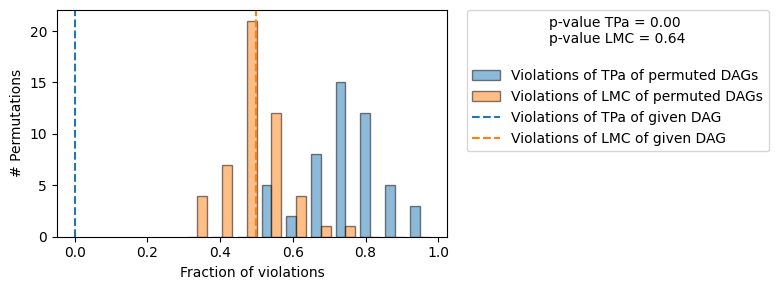

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [31]:
print(gcm.evaluate_causal_model(causal_model, data))


# causal discovery

  0%|          | 0/11 [00:00<?, ?it/s]

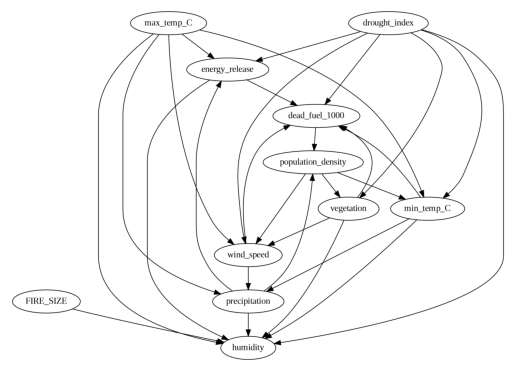

In [32]:
from causallearn.search.ConstraintBased.PC import pc

labels = [f'{col}' for i, col in enumerate(data.columns)]
data_np = data.to_numpy()

cg = pc(data_np)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(cg.G, labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

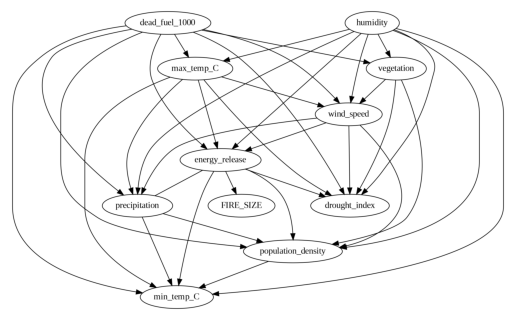

In [33]:
from causallearn.search.ScoreBased.GES import ges

# default parameters
Record = ges(data_np)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(Record['G'], labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

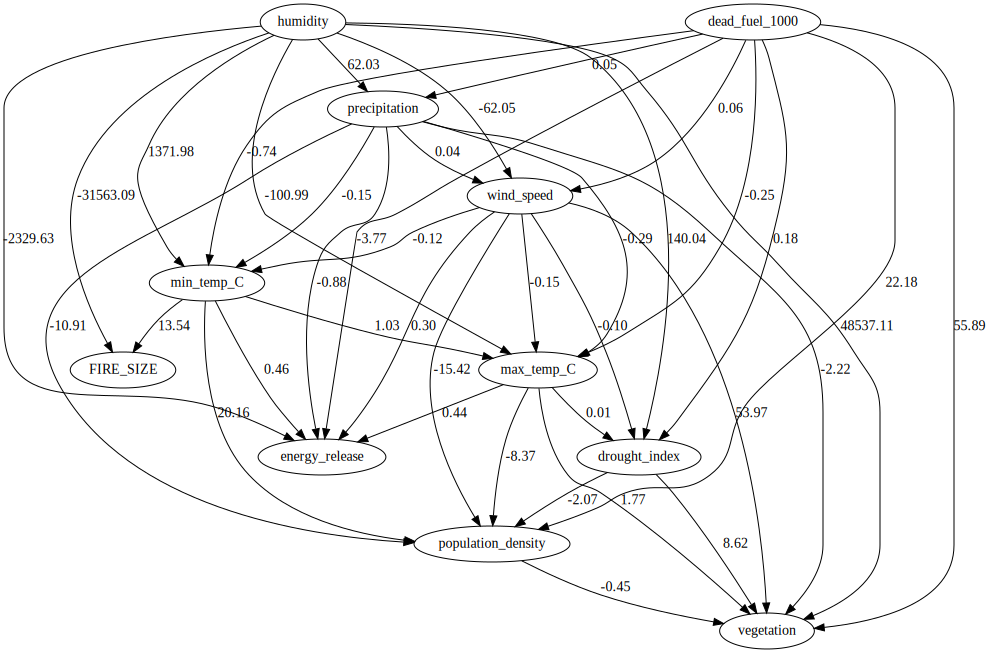

In [34]:
from causallearn.search.FCMBased import lingam
model = lingam.ICALiNGAM()
model.fit(data_np)

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model.adjacency_matrix_, labels=labels)